In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt
import itertools
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Model

In [8]:
model = nn.Sequential(
    
    nn.Linear(56, 90),
    nn.ReLU(),
    
    nn.Linear(90, 100),
    nn.ReLU(),
    
    nn.Linear(100, 120),
    nn.ReLU(),
    
    nn.Linear(120, 80),
    nn.ReLU(),
    
    nn.Linear(80, 60),
    nn.ReLU(),
    
    nn.Linear(60, 40),
    nn.ReLU(),
    
    nn.Linear(40, 20),
    nn.ReLU(),
    
    nn.Linear(20, 15),
    nn.ReLU(),
    
    nn.Linear(15, 10),
    nn.ReLU(),
    
    nn.Linear(10, 4),
)

In [2]:
states_walker2d= np.load("states_TRPO_walker2d_6.npy")[:4000]
actions_walker2d= np.load("actions_TRPO_walker2d_6.npy")[:4000]
states_walker2d = torch.tensor(states_walker2d, dtype=torch.float)
actions_walker2d = torch.tensor(actions_walker2d, dtype=torch.float)
print("states_walker2d.shape",states_walker2d.shape)
print("actions_walker2d.shape",actions_walker2d.shape)

states_walker2d.shape torch.Size([4000, 500, 24])
actions_walker2d.shape torch.Size([4000, 500, 4])


# preprocessing

In [3]:
############ for expert agent ############
def pre_processing (states, actions, n=3):
    ep, t, state_size = states.shape
    _,_, action_space = actions.shape
    output = torch.zeros ((ep*(t-n), n*(state_size+action_space)+action_space))
    index=0
    indices = []
    for i in range (ep):
        for j in range (t-n):
            output[index, : state_size*n] = states[i, j:j+n].view(-1)
            output[index, state_size*n: ]  = actions[i, j:j+n+1].view(-1)
            index+=1
    for i in range (output.shape[0]):
        if (output[i,n*state_size:] == -1*torch.ones((n+1)*action_space)).all() or (output[i,:state_size] == -1*torch.ones(state_size)).all():
            indices.append(i)
    cleaned_data = torch.tensor(np.delete(np.array(output), indices, axis=0))
    return cleaned_data
new_data  = pre_processing(states_walker2d, actions_walker2d, 2)
print("new_data.shape",new_data.shape)

new_data.shape torch.Size([1962015, 60])


In [4]:
# def pre_processing (array, n=3):
#     ep, t, _= array.shape
#     output = torch.zeros ((ep*(t-n), 4*(n+1)))
#     index=0
#     indices = []
#     for i in range (ep):
#         for j in range (t-n):
#             output[index] = array[i, j:j+n+1].view(-1)
#             index+=1
#     for i in range (output.shape[0]):
#         if (output[i] == -5*torch.ones(4*(n+1))).any():
#             indices.append(i)
#     cleaned_data = torch.tensor(np.delete(np.array(output), indices, axis=0))
#     return cleaned_data
# new_data  = pre_processing(actions_walker2d, 5)
# print("new_data.shape",new_data.shape)

new_data.shape torch.Size([1980000, 24])


In [5]:
training_set = new_data[:1000000]
testing_set = new_data[1000000:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([1000000, 60])
testing_set torch.Size([962015, 60])


# Train

In [9]:
losses = []
n_itrations=500
batch_size=256
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
for itr in range (n_itrations):
    if itr%50 == 0:
        torch.save(model, "act2vec/models/Walker2d_model_with_states_n=2")        
    total_loss = 0
    total_acc = []
    for b in range (0, training_set.shape[0], batch_size):
        y = torch.tensor(training_set[b:b+batch_size, 56:], dtype=torch.float)
        y_pred = model(training_set[b:b+batch_size, 0:56])
#         print("y_pred", y_pred)
        loss = loss_function(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if itr > 0:
        losses.append(total_loss)
    print("[EPOCH]: %i, [LOSS]: %.6f" % (itr, total_loss))

/home/montaser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


[EPOCH]: 0, [LOSS]: 498.902641
[EPOCH]: 1, [LOSS]: 174.380457
[EPOCH]: 2, [LOSS]: 120.454557
[EPOCH]: 3, [LOSS]: 102.169704
[EPOCH]: 4, [LOSS]: 90.871937
[EPOCH]: 5, [LOSS]: 83.125061
[EPOCH]: 6, [LOSS]: 77.346288
[EPOCH]: 7, [LOSS]: 72.853976
[EPOCH]: 8, [LOSS]: 69.410129
[EPOCH]: 9, [LOSS]: 66.678839
[EPOCH]: 10, [LOSS]: 64.543614
[EPOCH]: 11, [LOSS]: 62.769474
[EPOCH]: 12, [LOSS]: 61.313274
[EPOCH]: 13, [LOSS]: 60.030994
[EPOCH]: 14, [LOSS]: 58.979450
[EPOCH]: 15, [LOSS]: 58.040438
[EPOCH]: 16, [LOSS]: 57.247817
[EPOCH]: 17, [LOSS]: 56.504905
[EPOCH]: 18, [LOSS]: 55.876664
[EPOCH]: 19, [LOSS]: 55.286737
[EPOCH]: 20, [LOSS]: 54.751120
[EPOCH]: 21, [LOSS]: 54.269134
[EPOCH]: 22, [LOSS]: 53.870065
[EPOCH]: 23, [LOSS]: 53.449668
[EPOCH]: 24, [LOSS]: 53.033118
[EPOCH]: 25, [LOSS]: 52.619356
[EPOCH]: 26, [LOSS]: 52.265742
[EPOCH]: 27, [LOSS]: 51.933586
[EPOCH]: 28, [LOSS]: 51.608362
[EPOCH]: 29, [LOSS]: 51.327458
[EPOCH]: 30, [LOSS]: 51.045944
[EPOCH]: 31, [LOSS]: 50.834986
[EPOCH]: 32, [

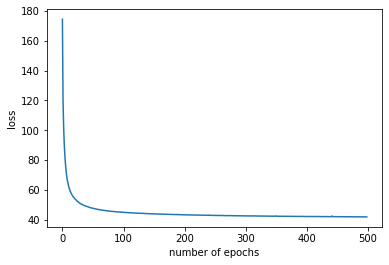

In [10]:
torch.save(model, "act2vec/models/Walker2d_model_with_states_n=2")
plt.plot(losses)
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()

# Test

In [12]:
y = torch.tensor(testing_set[85, 56:], dtype=torch.float)
y_pred = model(testing_set[85, :56])
print("y",y)
print("y_pred",y_pred)
print("loss",loss_function(y_pred, y).item())

y tensor([-0.1442,  1.0097,  0.7080, -0.8217])
y_pred tensor([-0.2439,  1.1769,  1.0296, -0.7970], grad_fn=<AddBackward0>)
loss 0.03546809405088425


/home/montaser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [41]:
def find_all_combination (n): 
    a=[-1.0,-0.5,0.0, 1.0,2.0]
    return torch.tensor([list(i) for i in itertools.product(a, repeat=4*n)], dtype=torch.float)
# def find_all_combination (n):
#     combination = torch.zeros((n*n,4*n), dtype=torch.float)
#     return torch.tensor([list(i) for i in itertools.product([0.0, 1.0], repeat=4*n)])

In [16]:
# m = torch.load( "act2vec/models/Walker2d_model_n=5")
m= model
m[:8]

Sequential(
  (0): Linear(in_features=84, out_features=90, bias=True)
  (1): ReLU()
  (2): Linear(in_features=90, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=120, bias=True)
  (5): ReLU()
  (6): Linear(in_features=120, out_features=80, bias=True)
  (7): ReLU()
)

In [17]:
def prepare_inputs (n): 
    m = -np.ones((1, 4*n))
    o2 = -0.5*np.ones((1, 4*n ))
    z = np.zeros((1, 4*n ))
    o1 = 0.5*np.ones((1, 4*n ))
    o = np.ones((1, 4*n ))
    zom = torch.tensor(np.concatenate((m, o2, z, o1, o), 0), dtype=torch.float)
    return zom

In [19]:
# zom = find_all_combination (4)
zom = prepare_inputs (3)
zom.shape

torch.Size([5, 12])

In [18]:
vectors = model[:9](zom).detach().numpy()
vectors.shape

(5, 30)

In [20]:
pca = PCA(n_components=2, svd_solver='full' ).fit_transform(vectors)
pca.shape

(5, 2)

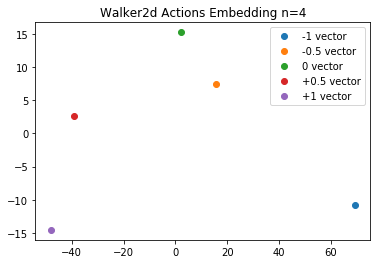

In [21]:
# for i in range (pca.shape[0]):
#     plt.plot(list(pca[i])[0], list(pca[i])[1] ,"o", label="{}".format(i))
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"o", label="-1 vector")
plt.plot(list(pca[1])[0], list(pca[1])[1] ,"o", label="-0.5 vector")
plt.plot(list(pca[2])[0], list(pca[2])[1] ,"o", label="0 vector")
plt.plot(list(pca[3])[0], list(pca[3])[1] ,"o", label="+0.5 vector")
plt.plot(list(pca[4])[0], list(pca[4])[1] ,"o", label="+1 vector")
plt.title("Walker2d Actions Embedding n=4")
plt.legend()
# plt.savefig("fig/Walker2d_n=4", dpi=600)

Text(0.5, 1.0, 'Kmeans Act2Vec Walker2d n=4')

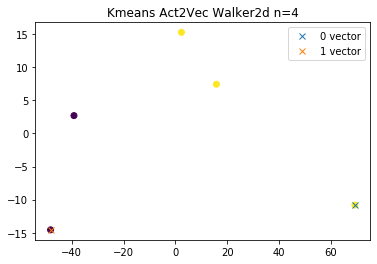

In [23]:
kmean = KMeans(n_clusters=2, random_state=0).fit_predict(pca)
plt.scatter(pca[:, 0], pca[:, 1], c=kmean)
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"x", label="0 vector")
# plt.plot(list(pca[200])[0], list(pca[200])[1] ,"x", label="0.5 vector")
plt.plot(list(pca[-1])[0], list(pca[-1])[1] ,"x", label="1 vector")
plt.legend()
plt.title("Kmeans Act2Vec Walker2d n=4")